# Hello there! Let's do some KNN on real estate

The basics of this is to utilize King County real estate information freely available from the King Count Accessor's office and determine if we can figure out what a house is worth.

We do this by utilizing K (the number) neighbors based on distances.

In [1]:
# First step is to load the packages that are important

import pandas as pd
import numpy as np
import random
from scipy.spatial import KDTree
from sklearn.metrics import mean_absolute_error,  mean_squared_error
import sys
import matplotlib.pyplot as plt

In [4]:
#  Load up the king county geocoded data.

df = pd.read_csv('../../data/king_county_data_geocoded.csv')
df

,AppraisedValue,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,...,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch,WaterProblems,TranspConcurrency,OtherProblems,lat,long
0,619000.0,6542712,1,1,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,47.354019,-122.225166
1,708000.0,105850,2,1,3,0,2,0,0,0,...,0,0,0,0,0,0,0,0,47.611248,-122.053154
2,297000.0,1667,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,47.701248,-122.365784
3,523000.0,1872,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,47.537918,-122.392845
4,288000.0,3480,2,2,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,47.510227,-122.182167
5,319000.0,546348,2,1,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,47.354980,-122.231277
6,523000.0,7221,2,2,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,47.699162,-122.280426
7,482000.0,12008,2,2,3,0,2,0,2,0,...,0,0,0,0,0,0,0,0,47.699230,-122.201538
8,228000.0,1017,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,47.730331,-122.355865
9,358000.0,1646,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,45.293430,-93.906406


In [5]:
df.columns

Index(['AppraisedValue', 'SqFtLot', 'WaterSystem', 'SewerSystem', 'Access',
       'Topography', 'StreetSurface', 'RestrictiveSzShape',
       'InadequateParking', 'PcntUnusable', 'MtRainier', 'Olympics',
       'Cascades', 'Territorial', 'SeattleSkyline', 'PugetSound',
       'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView',
       'WfntLocation', 'WfntFootage', 'WfntBank', 'WfntPoorQuality',
       'WfntRestrictedAccess', 'WfntAccessRights', 'WfntProximityInfluence',
       'TidelandShoreland', 'LotDepthFactor', 'TrafficNoise', 'PowerLines',
       'OtherNuisances', 'NbrBldgSites', 'Contamination',
       'AdjacentGolfFairway', 'AdjacentGreenbelt', 'HistoricSite',
       'CurrentUseDesignation', 'NativeGrowthProtEsmt', 'Easements',
       'OtherDesignation', 'DeedRestrictions', 'DevelopmentRightsPurch',
       'WaterProblems', 'TranspConcurrency', 'OtherProblems', 'lat', 'long'],
      dtype='object')

In [7]:
from sklearn.neighbors import KNeighborsRegressor

def regress(X, y, X_test, y_test, n_neighbors=2, metric='minkowski', p=2):

    reg = KNeighborsRegressor(n_neighbors=n_neighbors, metric=metric, p=p)

    y_column = 'AppraisedValue'

    reg.fit(X, y)

    return round(mean_absolute_error(y_test, reg.predict(X_test)), 2)

X = df[['lat', 'long', 'SqFtLot']]

# This normalizes using MinMaxScaling you can also use others
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
# The biggest issue is that the data comes in biased towards Seattle and biased
# towards a size of house > 900 sqft.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Note the below line is exactly the same as
# X = (X - X.min()) / (X.max() - X.min())
X = scaler.fit_transform(X)

# Try out some other columns if you want
# X = df[df.columns[~df.columns.isin(['AppraisedValue'])]]

# This is in dollar amounts
y = df['AppraisedValue']

# Try out some different n_neighbors or one of the distance metrics
# p = 2 for minkowski is a euclidean distance. p=1 is a manhattan distance.
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
# NOTE THAT n_neighbors=1 would be cheating in this case! so no cheating!
regress(X, y, X, y, n_neighbors=2, metric='minkowski', p=2)

43087.61

In [9]:
from sklearn.model_selection import train_test_split

# What happens when you change the test_size to 0.5 or 0.8 or 0.01?
# train(X), predict(X)

# X -> X_train, X_test. train(X_train), predict(X_test)

# Training, build the model on.
# Testing, what we evaluate on.

# 80 - 90% training
# 10 - 20% Testing.

X = df[['lat', 'long', 'SqFtLot']]

df

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

z = {'p': [], 'k': [], 'mae': []}

for p in range(1,10):
    for k in range(1,10):
        z['p'].append(p)
        z['k'].append(k)
        z['mae'].append(regress(X_train, y_train, X_test, y_test, n_neighbors=k, metric='minkowski', p=p))
        print(z['mae'][-1])
        
pd.DataFrame(z)

86311.66
78087.56
75589.4
74181.58
73619.78
73324.49
73062.47
72945.59
72917.01
86878.72
79529.87
76817.0
75356.15
74606.49
74419.87
74054.78
74085.36
74123.71
87381.4
79954.17
77310.4
75678.62
75088.98
74822.01
74739.57
74512.34
74557.72
87611.22
80131.74
77572.66
76010.8
75417.65
75158.57
75072.27
74950.98
74930.19
87621.89
80129.59
77519.75
76066.98
75488.85
75333.51
75162.53
75173.48
75134.7
87742.07
80121.5
77658.44
76216.74
75468.31
75517.52
75362.54
75315.88
75303.69
87732.0
80201.55
77756.67
76231.98
75546.1
75515.19
75385.56
75439.47
75429.28
87721.29
80204.8
77751.48
76333.05
75638.57
75672.13
75413.72
75481.57
75537.72
87762.17
80340.14
77683.28
76222.4
75632.75
75676.87
75391.58
75452.87
75555.09


,p,k,mae
0,1,1,86311.66
1,1,2,78087.56
2,1,3,75589.40
3,1,4,74181.58
4,1,5,73619.78
5,1,6,73324.49
6,1,7,73062.47
7,1,8,72945.59
8,1,9,72917.01
9,2,1,86878.72


/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


..

/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


...

/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


....

/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


.....

/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=6.
  % (min_groups, self.n_splits)), Warning)


......

/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=7.
  % (min_groups, self.n_splits)), Warning)


.......

/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


........

/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=9.
  % (min_groups, self.n_splits)), Warning)


.........

/home/hexgnu/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


..........

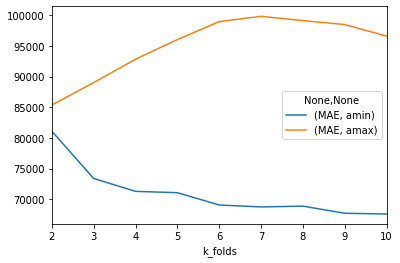

In [10]:
# Let's get more clever

from sklearn.model_selection import StratifiedKFold

# 2 split. 50/50
# 3 split. 33/33/33

error_data = []
for splits in range(2, 11):
    skf = StratifiedKFold(n_splits=splits)

    for train_index, test_index in skf.split(X, y):
        print('.', end='')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        error_data.append({'k_folds': splits,\
                           'MAE': regress(X_train, y_train, X_test, y_test, n_neighbors=6, metric='minkowski', p=2)\
                          })
pd.DataFrame(error_data).groupby('k_folds').agg({'MAE' : [np.min, np.max]}).plot()